## Dask Dataframes

Dask possibilita que também sejam utilizados dataframes para processamento paralelo e distribuído.

Como exemplo, carregaremos arquivos referentes a registros de vôos no aeroporto de Nova York:

Para fazer o download da base:

```python
import urllib, tarfile
print('Realizando download...', end=' ')
url = 'https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz'
filename, headers = urllib.request.urlretrieve(url, 'nycflights.tar.gz')
print('pronto.')

print('Descompactando...', end=' ')
with tarfile.open(filename, mode='r:gz') as flights:
    flights.extractall('base/')
print('pronto.')
```

In [ ]:
import urllib, tarfile
print('Realizando download...', end=' ')
url = 'https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz'
filename, headers = urllib.request.urlretrieve(url, 'nycflights.tar.gz')
print('pronto.')

print('Descompactando...', end=' ')
with tarfile.open(filename, mode='r:gz') as flights:
    flights.extractall('base/')
print('pronto.')
!ls base/nycflights

Como comparação, carregaremos primeiramente a base utilizando Pandas:

In [12]:
import pandas as pd
from glob import glob

df_pandas = pd.concat([pd.read_csv(file) for file in glob('base/nycflights/*.csv')])

Para abrir diversas bases, cada uma foi carregada em dataframe e armazenada em uma lista. Em seguida, estes dataframes foram concatenados, formando um único dataframe.

```python
df_pandas
```

In [ ]:
df_pandas

Agora carregamos as bases utilizando Dask dataframes:

```python
import dask.dataframe as dd

df = dd.read_csv('base/nycflights/*.csv')
```

In [1]:
import dask.dataframe as dd

df = dd.read_csv('base/nycflights/*.csv')

In [ ]:
df

**Atividade**
- Inicialmente, quais foram as diferenças?
    - ao carregar a base, com `.read_csv()`
    - ao visualizar a base

Podemos visualizar mais informações sobre o dataframe:

```python
df.dask
```

In [ ]:
df.dask

Vamos observar também o DAG gerado:

```python
df.visualize()
```

In [ ]:
df.visualize()

Um Dask Dataframe é composto por um conjunto de Pandas Dataframes. Vamos observar o tipo destes dataframes:

```python
type(df.partitions[0].compute())
```

E também a quantidade de dataframes:

```python
len(list(df.partitions))
```

In [ ]:
len(list(df.partitions))

Os arquivos ainda não foram carregados. Este passo será realizado ao executar o método `.compute()`.

Faremos isso em diferentes partes, observando alguns pontos.

```python
df.head()
```

In [ ]:
df.head()

Neste passo, observaremos um erro.

```python
df.tail()
```

In [ ]:
df.tail()

Ao observar os erros:

```
ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+
```

Este erro ocorreu porque o Dask estimou os tipos de dados com base nas primeiras linhas. Porém, haviam outras linhas da base em que o tipo de dado na coluna era diferente.

Para corrigir estes erros, devemos informar manualmente os tipos de dados de algumas colunas ao carregar a base.

```python
df = dd.read_csv('base/nycflights/*.csv', dtype={'TailNum': str, 'CRSElapsedTime':float})
df.tail()
```

In [8]:
df = dd.read_csv('base/nycflights/*.csv', dtype={'TailNum': str, 'CRSElapsedTime':float})
df.tail()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999,12,27,1,1645.0,1645,1830.0,1901,UA,1753,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,0,0
269177,1999,12,28,2,1726.0,1645,1928.0,1901,UA,1753,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,0,0
269178,1999,12,29,3,1646.0,1645,1846.0,1901,UA,1753,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,0,0
269179,1999,12,30,4,1651.0,1645,1908.0,1901,UA,1753,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,0,0
269180,1999,12,31,5,1642.0,1645,1851.0,1901,UA,1753,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,0,0


In [ ]:
df.visualize()

## Realizando operações

Como exemplo, vamos tentar obter o maior valor presente em cada coluna, utilizando o método `.max()`.

```python
df_maiores = df.max()
```

In [9]:
df_maiores = df.max()

Observando o DAG:
```python
maiores_valores.visualize()
```
ou então, apresentando com outro *layout*:
```python
df_maiores.visualize(rankdir='LR', size='12,12!')
```

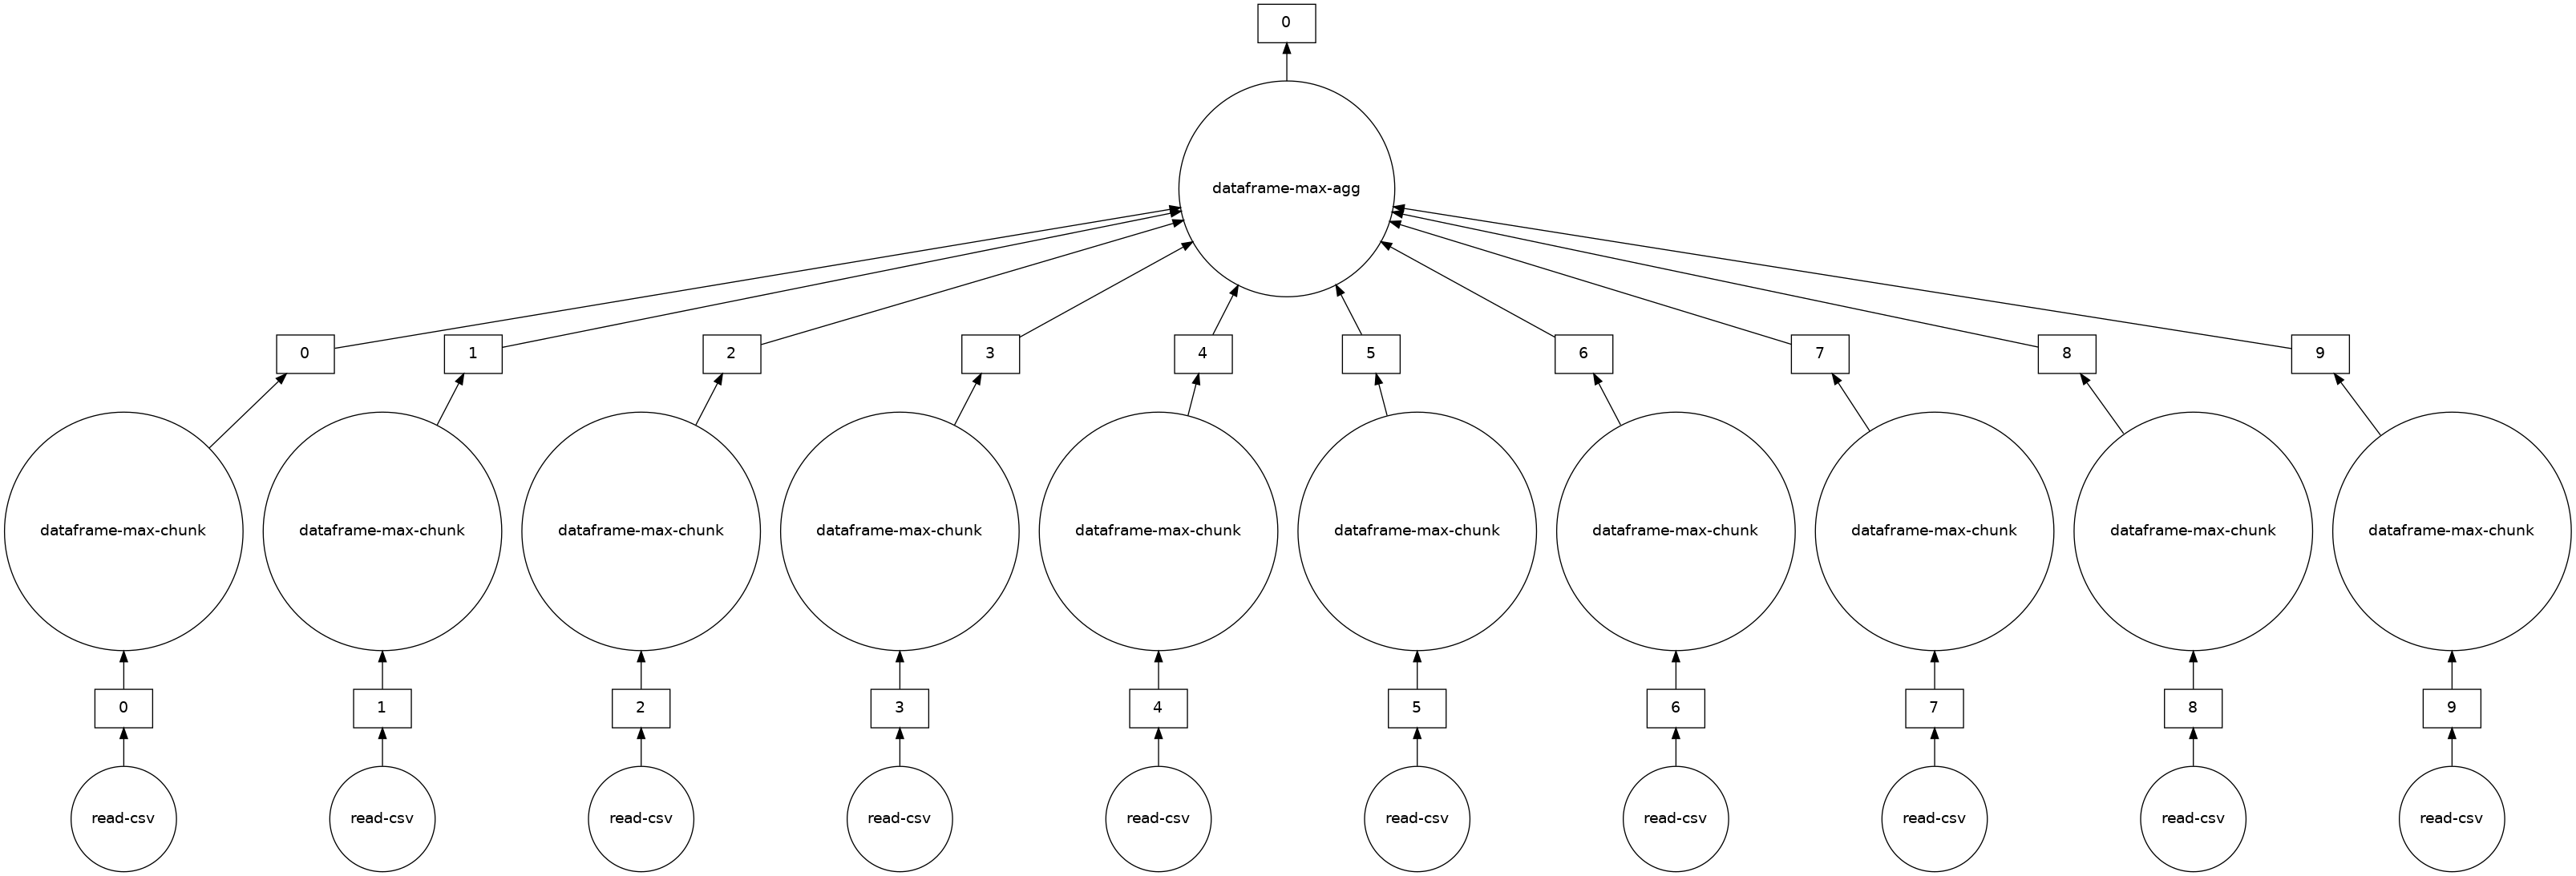

In [16]:
df_maiores.visualize()

Ou então
```python
df_maiores.visualize(rankdir='LR', size='12,12!')
```

Calculando os maiores valores
```python
df_maiores.compute()
```

In [15]:
%%time
df_maiores.compute()

CPU times: user 6.43 s, sys: 460 ms, total: 6.89 s
Wall time: 3.55 s


Year                   1999
Month                    12
DayofMonth               31
DayOfWeek                 7
DepTime              2400.0
CRSDepTime             2359
ArrTime              2400.0
CRSArrTime             2400
UniqueCarrier            US
FlightNum              9899
ActualElapsedTime     795.0
CRSElapsedTime        726.0
AirTime              1082.0
ArrDelay             1156.0
DepDelay             1435.0
Origin                  LGA
Dest                    TYS
Distance             4962.0
TaxiIn                783.0
TaxiOut               428.0
Cancelled                 1
Diverted                  1
dtype: object

In [14]:
%%time
df_pandas.max()

CPU times: user 1.37 s, sys: 2.74 ms, total: 1.37 s
Wall time: 1.41 s


Year                   1999
Month                    12
DayofMonth               31
DayOfWeek                 7
DepTime              2400.0
CRSDepTime             2359
ArrTime              2400.0
CRSArrTime             2400
UniqueCarrier            US
FlightNum              9899
ActualElapsedTime     795.0
CRSElapsedTime        726.0
AirTime              1082.0
ArrDelay             1156.0
DepDelay             1435.0
Origin                  LGA
Dest                    TYS
Distance             4962.0
TaxiIn                783.0
TaxiOut               428.0
Cancelled                 1
Diverted                  1
dtype: object

## Referências

- [Dask. Scale the Python tools you love.](https://docs.dask.org/en/stable/)  
- [BOCHMAN, D. Dask: Machine Learning & Data Science Open-source Spotlight. Youtube.](https://www.youtube.com/watch?v=Alwgx_1qsj4&t=755s)
- [ROCKLIN, M. Dask DataFrame: An Introduction. Youtube](https://www.youtube.com/watch?v=AT2XtFehFSQ&t=262s)